In [2]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## kNN method

## 1. DESI, SDSS, Quaia triple considered

In [3]:
superset = fits.open('Quaia_DESIQSO_DR1_SDSS.fits')
data = superset[1].data

train_mask = (~np.isnan(data['DESI_Z']))
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

train_data 개수: 314807


In [4]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'Quaia_W12'
            ]

valid_mask = (np.isnan(data['DESI_Z']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['redshift_quaia']
#y_train = np.where(~np.isnan(filtered_data['DESI_Z']), 
#                   filtered_data['redshift_quaia'],
#                   filtered_data['DESI_Z']) 
X_test = np.array([filtered_data[f] for f in features]).T
y_test = filtered_data['DESI_Z']


print("X_train NaN 개수:", np.isnan(X_train).sum())
print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))
print(filtered_data.shape)

X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (980695, 6)
각 feature 별 NaN 개수: [0 0 0 0 0 0]
test_mask에서 True 개수: 980695
(980695,)


kNN 1. cKDTree
    2. kNeighborRegressor

cKDTree : redshifts are predicted within the priorities of each sets. for now, distance-based weight applied (Gaussian) and normalized.

In [5]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
#sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
#weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
#weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화
#z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

Y_neighbors = y_train_clean[inds]
# 모든 이웃에게 동일한 가중치 부여
weights = np.full_like(Y_neighbors, fill_value=1 / K, dtype=np.float64)

z_phot_predictions = np.sum(Y_neighbors * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test] 

for i, pred in zip(valid_test_indices, z_phot_predictions):
    quaia = data['redshift_quaia'][i]
    desi = data['DESI_Z'][i]
    
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1

    if count >= max_print:
        break

peak memory: 1167.38 MiB, increment: 0.26 MiB


In [6]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions.shape)
print("z_phot_predictions sample:", z_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

#hdu.writeto("superset_with_zphot_new2.fits", overwrite=True)
hdu.writeto("superset_with_z1.fits", overwrite=True)


z_phot_predictions shape: (980695,)
z_phot_predictions sample: [0.44112469 0.35765779 0.49887071 1.37539311 0.40893335 0.63537958
 1.96038829 0.88695893 1.62776304 1.0273884 ]
test_mask에서 True 개수: 980695
X_test_clean shape: (980695, 6)


In [7]:
photo_z = fits.open('superset_with_zphot_new2.fits')
photo_z_data = photo_z[1].data

print(photo_z_data['Photo_z_QD'])

[0.44258898 1.4579604  1.4903299  ... 0.5870953  2.629491   2.4660234 ]


## 1-1. knn method from Quaia used with KNeighborsRegressor

In [8]:
%load_ext memory_profiler
%memit

# X_test NaN 처리
imputer = SimpleImputer(strategy='mean')  # 평균값으로 NaN 대체

# 스케일링
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 스케일링 확인
for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

#knn = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='euclidean')
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# kNN 예측
z_phot_predictions1 = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(z_phot_predictions1[:5])

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 2147.91 MiB, increment: 0.00 MiB
phot_g_mean_mag: mean = 19.7086, std = 0.6638
phot_bp_mean_mag: mean = 19.9009, std = 0.6681
phot_rp_mean_mag: mean = 19.2116, std = 0.6723
mag_w1_vg: mean = 15.8691, std = 0.8800
mag_w2_vg: mean = 14.8035, std = 0.8966
Quaia_W12: mean = 1.0656, std = 0.2137
MAE: 0.1951, RMSE: 0.2793
[0.4489208  0.37953949 0.50421232 1.44534121 0.46483845]


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

for pred, quaia, desi, sdss in zip(z_phot_predictions1, 
                                   data['redshift_quaia'], 
                                   data['DESI_Z'], 
                                   data['SDSS_Z']):
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi) or np.isnan(sdss)):
        print(f"predicted redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\nSDSS redshift: {sdss}\n")
        count += 1
    
    if count >= max_print:
        break  

predicted redshift: 1.4453412076097354
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774
SDSS redshift: 2.414

predicted redshift: 0.46483845267295837
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424
SDSS redshift: 2.863

predicted redshift: 1.692469185302317
Quaia redshift: 0.821638286113739
DESI redshift: 0.8104069564257644
SDSS redshift: 0.8101370334625244

predicted redshift: 1.8330395698547364
Quaia redshift: 0.4740816652774811
DESI redshift: 0.4708462042020013
SDSS redshift: 0.4703986942768097

predicted redshift: 1.3579074144363403
Quaia redshift: 1.8770912885665894
DESI redshift: 1.8636456256865628
SDSS redshift: 1.8628448247909546



In [10]:
header = superset[1].header  

new_col_zphot1 = np.full(data.shape[0], np.nan) 
test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot1[valid_test_indices] = z_phot_predictions1

new_cols1 = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot1)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols1, header=header)

#hdu.writeto("superset_with_zphot_kNR2.fits", overwrite=True)


In [11]:
print("X_train min/max:", np.nanmin(X_train, axis=0), np.nanmax(X_train, axis=0))
print("X_test min/max:", np.nanmin(X_test, axis=0), np.nanmax(X_test, axis=0))

nan_percentage = (np.isnan(X_train).sum() / X_train.size) * 100
print(f"NaN 비율: {nan_percentage:.2f}%")

X_train min/max: [-8.77651383 -8.84106955 -8.54184964 -8.87363108 -8.2191227  -3.11374459] [1.19215495 4.16164461 4.80697877 2.71352601 2.73855687 8.2088969 ]
X_test min/max: [-8.77651383 -8.84106955 -8.54184964 -8.87363108 -8.2191227  -3.11374459] [1.19215495 4.16164461 4.80697877 2.71352601 2.73855687 8.2088969 ]
NaN 비율: 0.00%


In [12]:
import pandas as pd

df_train = pd.DataFrame(X_train_clean, columns=features)
print(df_train.describe())

df_test = pd.DataFrame(X_test_clean, columns=features)
print(df_test.describe())


       phot_g_mean_mag  phot_bp_mean_mag  phot_rp_mean_mag      mag_w1_vg  \
count    980695.000000     980695.000000     980695.000000  980695.000000   
mean         19.708597         19.900867         19.211585      15.869111   
std           0.663841          0.668128          0.672253       0.879971   
min          13.882390         13.993901         13.469306       8.060579   
25%          19.366238         19.569709         18.867183      15.347713   
50%          19.875032         20.066212         19.364550      15.976443   
75%          20.220453         20.387573         19.708963      16.506368   
max          20.499998         22.681377         22.443089      18.256933   

           mag_w2_vg      Quaia_W12  
count  980695.000000  980695.000000  
mean       14.803537       1.065574  
std         0.896619       0.213745  
min         7.434118       0.400028  
25%        14.283565       0.926891  
50%        14.886782       1.080509  
75%        15.426042       1.218112  
ma

In [13]:
# NaN이 있는 데이터 제거
desi_z_clean = data['DESI_Z'][valid_mask][~nan_mask_test]  

# 차이 계산
diff = np.abs(z_phot_predictions - desi_z_clean)

print("평균 차이:", np.mean(diff))
print("중앙값 차이:", np.median(diff))
print("최대 차이:", np.max(diff))

quaia_vs_desi_diff = np.abs(data['redshift_quaia'] - data['DESI_Z'])

print(f"Quaia vs. DESI 평균 차이: {np.nanmean(quaia_vs_desi_diff)}")
print(f"Quaia vs. DESI 중앙값 차이: {np.nanmedian(quaia_vs_desi_diff)}")
print(f"Quaia vs. DESI 최대 차이: {np.nanmax(quaia_vs_desi_diff)}")

quaia_vs_photoz_diff = np.abs(data['redshift_quaia'] - new_col_zphot)

print(f"Quaia vs. kNN Photo-z 평균 차이: {np.nanmean(quaia_vs_photoz_diff)}")
print(f"Quaia vs. kNN Photo-z 중앙값 차이: {np.nanmedian(quaia_vs_photoz_diff)}")
print(f"Quaia vs. kNN Photo-z 최대 차이: {np.nanmax(quaia_vs_photoz_diff)}")

quaia_vs_photoz_diff2 = np.abs(data['redshift_quaia'] - new_col_zphot1)

print(f"Quaia vs. kNN Photo-z2 평균 차이: {np.nanmean(quaia_vs_photoz_diff2)}")
print(f"Quaia vs. kNN Photo-z2 중앙값 차이: {np.nanmedian(quaia_vs_photoz_diff2)}")
print(f"Quaia vs. kNN Photo-z2 최대 차이: {np.nanmax(quaia_vs_photoz_diff2)}")

평균 차이: nan
중앙값 차이: nan
최대 차이: nan
Quaia vs. DESI 평균 차이: 0.1247888796360761
Quaia vs. DESI 중앙값 차이: 0.01571005305700246
Quaia vs. DESI 최대 차이: 4.794040567381018
Quaia vs. kNN Photo-z 평균 차이: 0.2087218776332476
Quaia vs. kNN Photo-z 중앙값 차이: 0.14011349504644244
Quaia vs. kNN Photo-z 최대 차이: 3.0379169668774386
Quaia vs. kNN Photo-z2 평균 차이: 0.19513669617206061
Quaia vs. kNN Photo-z2 중앙값 차이: 0.13110594735145564
Quaia vs. kNN Photo-z2 최대 차이: 2.960787865501864


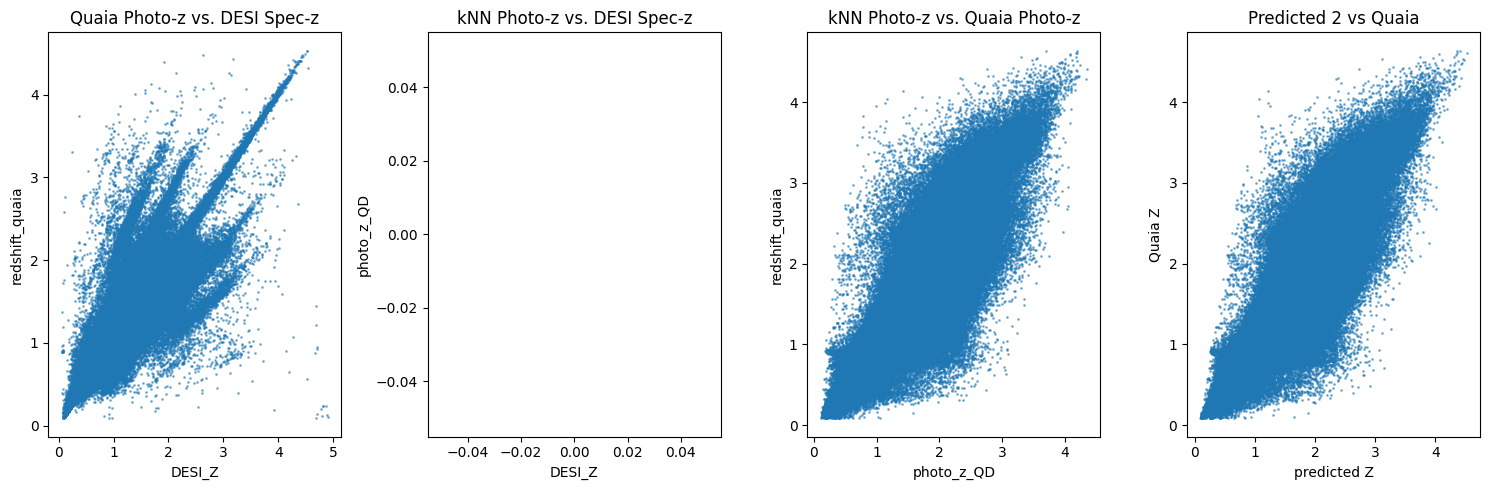

In [14]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 4, 1)
plt.scatter(data['DESI_Z'], data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("redshift_quaia")
plt.title("Quaia Photo-z vs. DESI Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 4, 2)
plt.scatter(data['DESI_Z'], new_col_zphot, alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 4, 3)
plt.scatter(new_col_zphot, data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("photo_z_QD")
plt.ylabel("redshift_quaia")
plt.title("kNN Photo-z vs. Quaia Photo-z")

# 4. kNN z ver.2 vs DESI
plt.subplot(1, 4, 4)
plt.scatter(new_col_zphot1, data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("predicted Z")
plt.ylabel("Quaia Z")
plt.title("Predicted 2 vs Quaia")

plt.tight_layout()
plt.show()


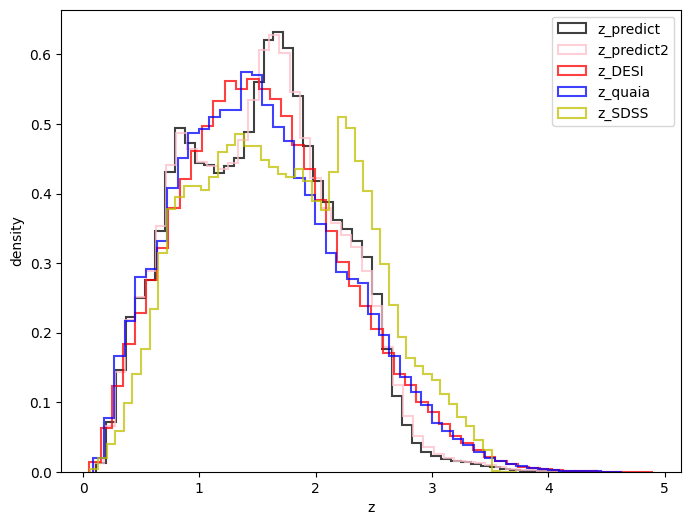

In [15]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(new_col_zphot, bins=50, alpha=alpha, color='black', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(new_col_zphot1, bins=50, alpha=alpha, color='pink', lw=lw, density=density, histtype=histtype, label='z_predict2')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

# 2. Two considered

DESI_Quaia

In [16]:
train_mask = (~np.isnan(data['DESI_Z'])) & (~np.isnan(data['redshift_quaia']))
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

train_data 개수: 314807


In [17]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]

valid_mask = (~np.isnan(data['DESI_Z'])) & (~np.isnan(data['redshift_quaia']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = np.where(~np.isnan(filtered_data['DESI_Z']), 
                   filtered_data['DESI_Z'],  # DESI redshift 우선
                   filtered_data['redshift_quaia'])  # 없으면 Quaia redshift 사용
X_test = X_train.copy()  # 같은 데이터에서 테스트 진행

print("X_train NaN 개수:", np.isnan(X_train).sum())

print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))

X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (314807, 5)
각 feature 별 NaN 개수: [0 0 0 0 0]
test_mask에서 True 개수: 314807


In [18]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화

# 최종 예측값 계산
z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

for pred, quaia, desi in zip(z_phot_predictions, 
                                   data['redshift_quaia'], 
                                   data['DESI_Z']):
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1
    
    if count >= max_print:
        break  

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 2184.68 MiB, increment: 0.00 MiB
예측된 redshift: 0.3820810242273529
Quaia redshift: 0.41686686873435974
DESI redshift: 0.4099723683396368

예측된 redshift: 1.716662810710343
Quaia redshift: 1.7364680767059326
DESI redshift: 1.7403967224566679

예측된 redshift: 1.4403468496737588
Quaia redshift: 1.5130492448806763
DESI redshift: 1.5029969100152152

예측된 redshift: 2.2524345343905225
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774

예측된 redshift: 2.2450301664852548
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424



In [19]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions.shape)
print("z_phot_predictions sample:", z_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

#hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("superset_with_zphot_new3.fits", overwrite=True)


z_phot_predictions shape: (314807,)
z_phot_predictions sample: [0.38208102 1.71666281 1.44034685 2.25243453 2.24503017 1.60609188
 0.71516421 0.78381703 2.01116548 1.29502435]
test_mask에서 True 개수: 314807
X_test_clean shape: (314807, 5)


DESI, SDSS considered

In [20]:
train_mask = (~np.isnan(data['DESI_Z'])) & (~np.isnan(data['SDSS_Z']))
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]

valid_mask = (~np.isnan(data['DESI_Z'])) & (~np.isnan(data['SDSS_Z']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = np.where(~np.isnan(filtered_data['DESI_Z']), 
                   filtered_data['DESI_Z'],  # DESI redshift 우선
                   filtered_data['SDSS_Z'])  # 없으면 Quaia redshift 사용
X_test = X_train.copy()  # 같은 데이터에서 테스트 진행

print("X_train NaN 개수:", np.isnan(X_train).sum())

print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))

train_data 개수: 101233
X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (101233, 5)
각 feature 별 NaN 개수: [0 0 0 0 0]
test_mask에서 True 개수: 101233


In [21]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화

# 최종 예측값 계산
z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

for pred, sdss, desi in zip(z_phot_predictions, 
                                   data['SDSS_Z'], 
                                   data['DESI_Z']):
    if not (np.isnan(pred) or np.isnan(sdss) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nSDSS redshift: {sdss}\nDESI redshift: {desi}\n")
        count += 1
    
    if count >= max_print:
        break  

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1813.11 MiB, increment: 0.00 MiB
예측된 redshift: 0.6975488744891123
SDSS redshift: 2.414
DESI redshift: 2.424188775557774

예측된 redshift: 1.7732382433021932
SDSS redshift: 2.863
DESI redshift: 2.869778073634424

예측된 redshift: 1.192986580860663
SDSS redshift: 0.8101370334625244
DESI redshift: 0.8104069564257644

예측된 redshift: 1.9246564922473173
SDSS redshift: 0.4703986942768097
DESI redshift: 0.4708462042020013

예측된 redshift: 2.0747684130992017
SDSS redshift: 1.8628448247909546
DESI redshift: 1.8636456256865628



In [22]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions.shape)
print("z_phot_predictions sample:", z_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

#hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("superset_with_zphot_new4.fits", overwrite=True)


z_phot_predictions shape: (101233,)
z_phot_predictions sample: [2.44248497 2.41419964 0.71648143 0.69754887 1.77323824 0.25811793
 1.19298658 2.13755465 1.66188093 1.03034466]
test_mask에서 True 개수: 101233
X_test_clean shape: (101233, 5)


In [23]:
zphot3 = fits.open('superset_with_zphot_new3.fits')
zphot3_data = zphot3[1].data

zphot4 = fits.open('superset_with_zphot_new4.fits')
zphot4_data = zphot4[1].data

desiquaia_z = zphot3_data['Photo_z_QD']
desisdss_z = zphot4_data['Photo_z_QD']

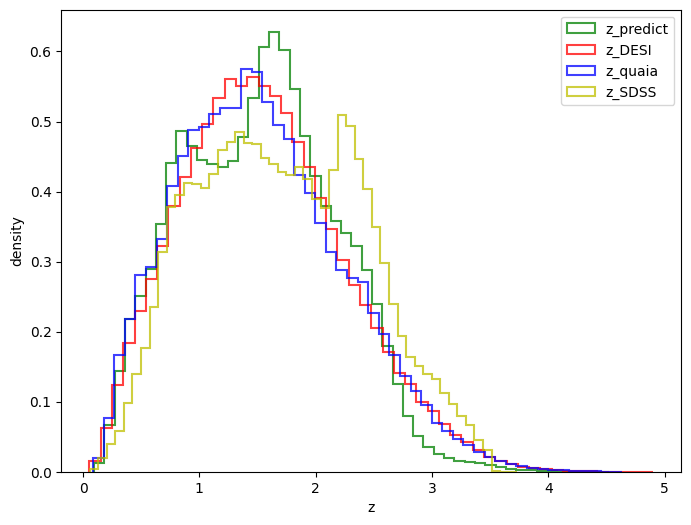

In [24]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(desisdss_z, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

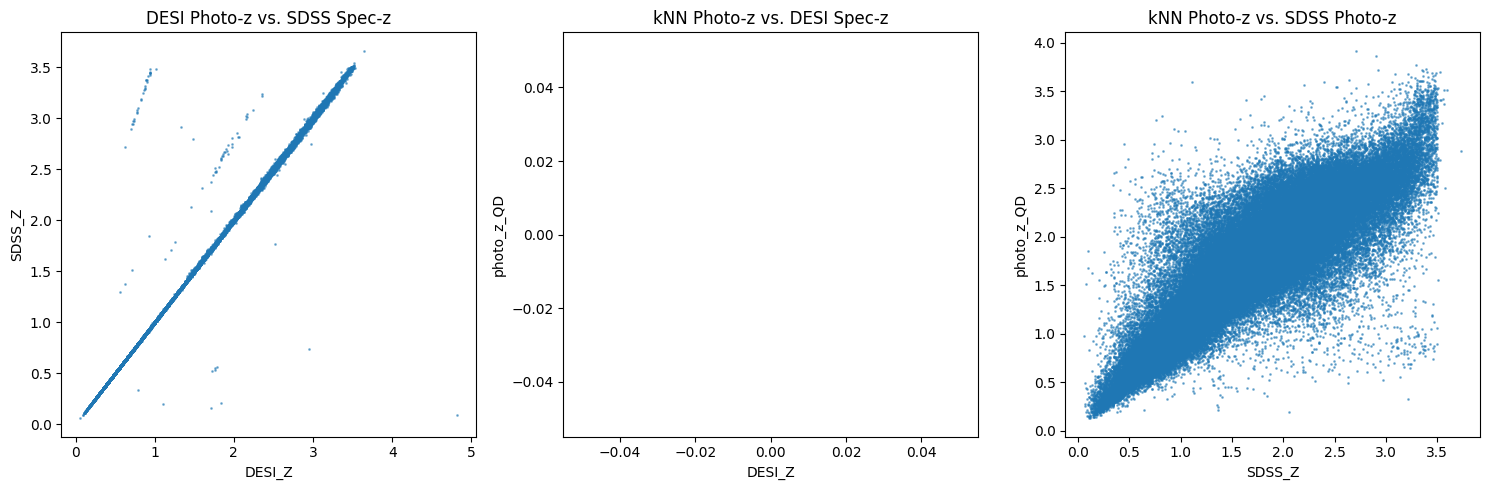

In [25]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(data['DESI_Z'], data['SDSS_Z'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("SDSS_Z")
plt.title("DESI Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(data['DESI_Z'], desisdss_z, alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(data['SDSS_Z'], desisdss_z, alpha=0.5, s=1)
plt.xlabel("SDSS_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. SDSS Photo-z")

plt.tight_layout()
plt.show()


# 3. Checking all the fits data

kNN (kNeighborRegressor)

In [26]:
superset_kNR = fits.open('superset_with_zphot_kNR2.fits')
kNR_data = superset_kNR[1].data

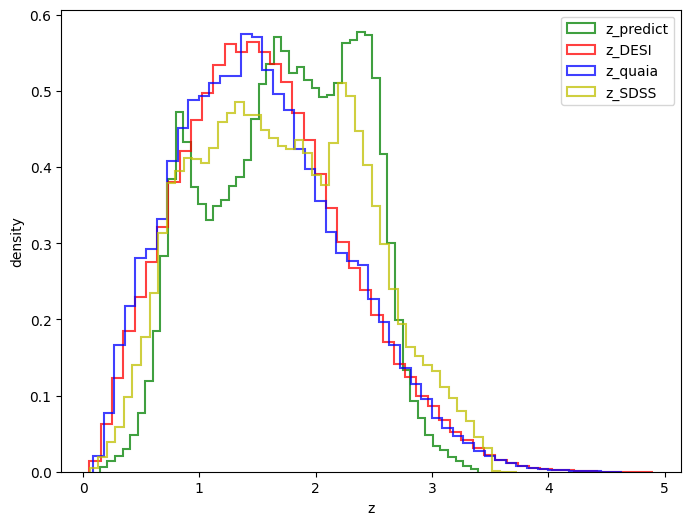

In [27]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(kNR_data['Photo_z_QD'], bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(kNR_data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(kNR_data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(kNR_data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'number per bin')

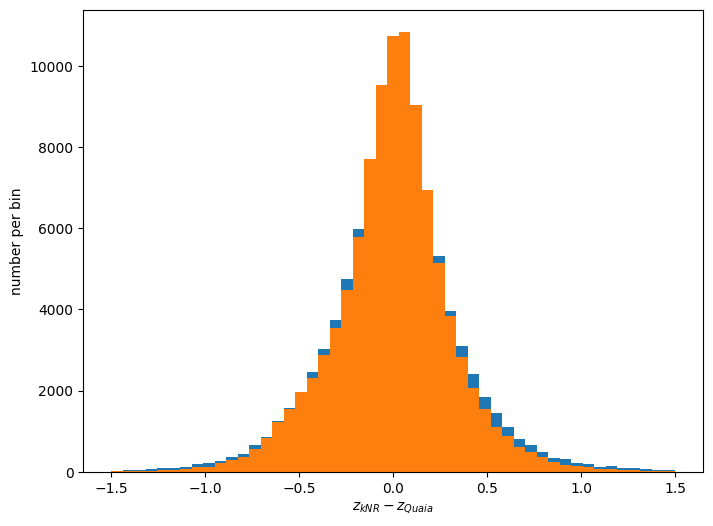

In [28]:
plt.figure(figsize=(8, 6))

bins = np.linspace(-1.5, 1.5, 50)
plt.hist(kNR_data['Photo_Z_QD'] - kNR_data['DESI_Z'], bins=bins)
plt.xlabel(r'$z_{kNR} - z_{DESI}$')
plt.ylabel('number per bin')

bins1 = np.linspace(-1.5, 1.5, 50)
plt.hist(kNR_data['Photo_Z_QD'] - kNR_data['redshift_quaia'], bins=bins1)
plt.xlabel(r'$z_{kNR} - z_{Quaia}$')
plt.ylabel('number per bin')

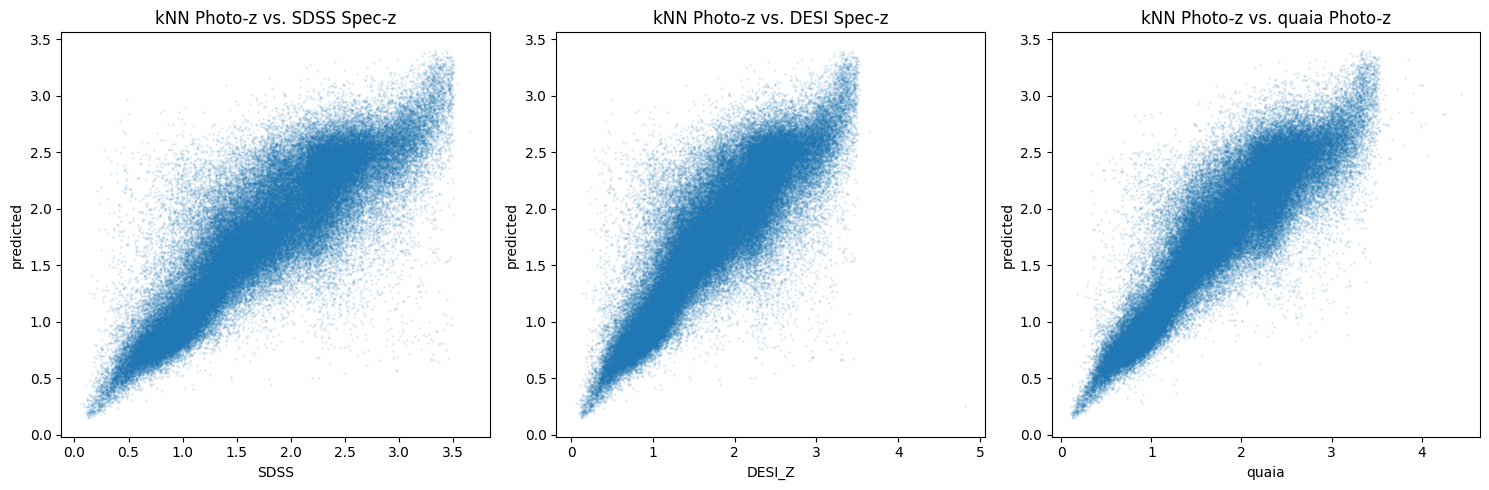

In [34]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(kNR_data['SDSS_Z'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(kNR_data['DESI_Z'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(kNR_data['redshift_quaia'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("quaia")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. quaia Photo-z")

plt.tight_layout()
plt.show()


kNN (cKDTree)

In [30]:
z1 = fits.open('superset_with_z1.fits')
z1data = z1[1].data

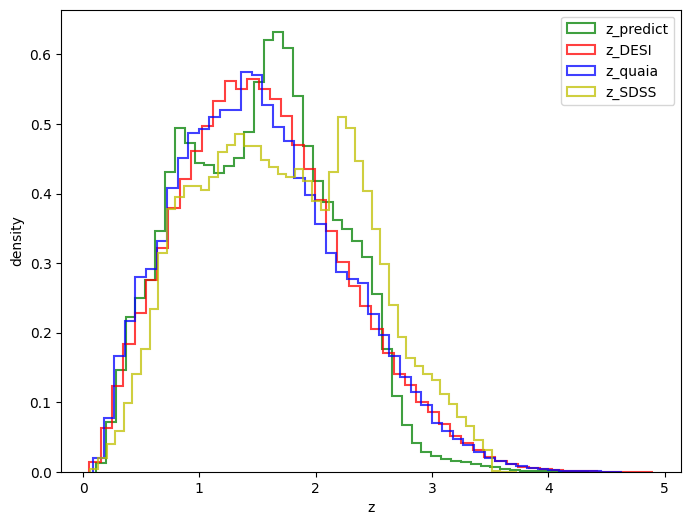

In [31]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z1data['Photo_z_QD'], bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(z1data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(z1data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(z1data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

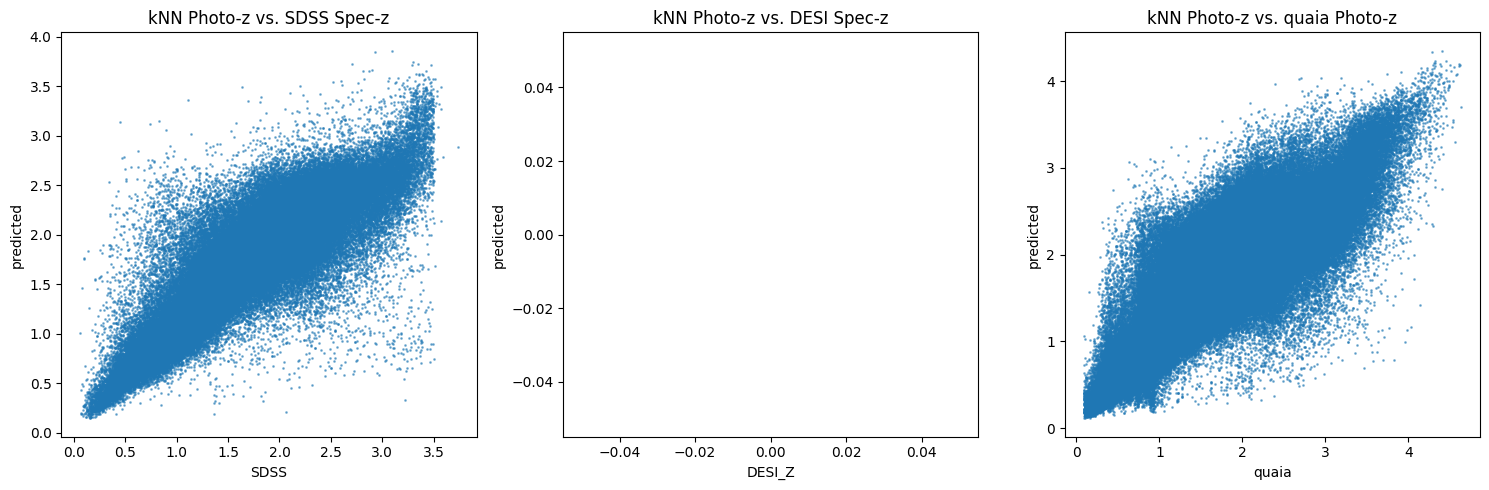

In [33]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(z1data['SDSS_Z'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(z1data['DESI_Z'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(z1data['redshift_quaia'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("quaia")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. quaia Photo-z")

plt.tight_layout()
plt.show()
